# Imports

In [1]:
# link to all dfs: https://nijianmo.github.io/amazon/index.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import twokenize # from homework 2b
from porter_stemmer import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
import tensorflow_hub as hub
import re
from tensorflow.keras import layers
import torch 
from transformers import AutoModelForSequenceClassification, AutoTokenizer

2023-04-29 09:28:46.521906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Read Data

In [2]:
def read_df(filename):
    df = pd.read_json(filename, lines = True)
    df["reviewTime"] = pd.to_datetime(df["reviewTime"])
    df = df.drop_duplicates(subset = ["reviewTime", "reviewerID", "asin"])
    df = df.drop(columns = ["verified", "reviewTime", "reviewerID", "asin", "reviewerName", 
                       "unixReviewTime", "vote", "style", "image"])
    df = df.dropna(subset = ['reviewText'])
    df = df.reset_index(drop = True)
    return df

In [3]:
# https://jmcauley.ucsd.edu/data/amazon_v2/categoryFilesSmall/Toys_and_Games_5.json.gz
df = read_df("data/Video_Games_5.json")

# never used, just saved in case something happens to df
df1 = df.copy(deep = True)

df = df.iloc[:10000,:]
df = df.sample(frac = 1)

# Prepare Features

In [4]:
# code taken from homework 2b student_code.py
stemmer = PorterStemmer()
stop_words = set([x.strip() for x in open("res/stopwords.english", encoding="ISO-8859-1").readlines()])

neg_words =  set([x.strip() for x in open("res/negative-words.txt", encoding="ISO-8859-1").readlines() if not(x.startswith(";"))])
neg_words.remove("")

pos_words =  set([x.strip() for x in open("res/positive-words.txt", encoding="ISO-8859-1").readlines() if not(x.startswith(";"))])
pos_words.remove("")

In [5]:
features = {
    'contains_!' : lambda x: int("!" in x),
    'num_positive' : lambda x: sum([word.lower() in pos_words for word in twokenize.tokenize(x)]),
    'num_negative' : lambda x: sum([word.lower() in neg_words for word in twokenize.tokenize(x)]),
    'length' : len
}

# TODO: unigram, bigram features? - this could get ugly, 
# but I guess we dont have to look at summary of logreg, just test performance

In [6]:
X = pd.DataFrame()

features = {
    'contains_!' : lambda x: int("!" in x),
    'num_positive' : lambda x: sum([word.lower() in pos_words for word in twokenize.tokenize(x)]),
    'num_negative' : lambda x: sum([word.lower() in neg_words for word in twokenize.tokenize(x)]),
    'length' : len
}

# build up the features data-matrix X by applying all of the features
review_strings = df['reviewText'].astype(str)
for feature, f in features.items():
    X[feature] = review_strings.apply(f)
    
Y = np.where(df.overall <= 3, 0, 1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33)

# Helper Functions

In [8]:
def metrics(y_hat, y, threshold = 0.5, target = "positive"):
    
    if isinstance(y_hat, np.ndarray):
        y_hat = y_hat.flatten()
    
    predicted = (pd.Series(y_hat) > threshold).astype(int).reset_index(drop = True)
    actual = pd.Series(y).astype(int).reset_index(drop = True)
            
    TP = (actual * predicted).astype(bool).sum()
    TN = ((actual-1) * (predicted-1)).astype(bool).sum()
    FP = ((actual-1) * predicted).astype(bool).sum()
    FN = (actual * (predicted-1)).astype(bool).sum()
            
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    
    if target == "positive":
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        
    if target == "negative":
        precision = TN / (TN + FN)
        recall = TN / (TN + FP)
        
    f = 2 / (1/precision + 1/recall)
    
    return accuracy, precision, recall, f

def roc(y, y_hat, target = "positive"):
    if target == "positive":
        FP, TP, _ = roc_curve(y, y_hat)
        plt.plot(FP, TP, label = "positive")
    if target == "negative":
        y = -1 * y + 1
        y_hat = -1 * y_hat + 1
        FP, TP, _ = roc_curve(y, y_hat)
        plt.plot(FP, TP, label = "negative")

In [9]:
positive_metrics = pd.DataFrame(index = ["LR", "NB", "NN", "GRU", "BERT"], 
                                columns = ["Accuracy", "Precision", "Recall", "F"])
negative_metrics = pd.DataFrame(index = ["LR", "NB", "NN", "GRU", "BERT"], 
                                columns = ["Accuracy", "Precision", "Recall", "F"])

# 1) Logistic Regression

In [10]:
model = LogisticRegression(class_weight = "balanced").fit(X_train, y_train)
y_hat = model.predict(X_test)

In [11]:
positive_metrics.loc["LR",:] = metrics(y_hat, y_test, threshold = 0.5, target = "positive")
negative_metrics.loc["LR",:] = metrics(y_hat, y_test, threshold = 0.5, target = "negative")

# 2) Naive Bayes

In [12]:
model = ComplementNB().fit(X_train, y_train)
y_hat = model.predict(X_test)

In [13]:
positive_metrics.loc["NB",:] = metrics(y_hat, y_test, target = "positive")
negative_metrics.loc["NB",:] = metrics(y_hat, y_test, target = "negative")

# 3) Neural Network

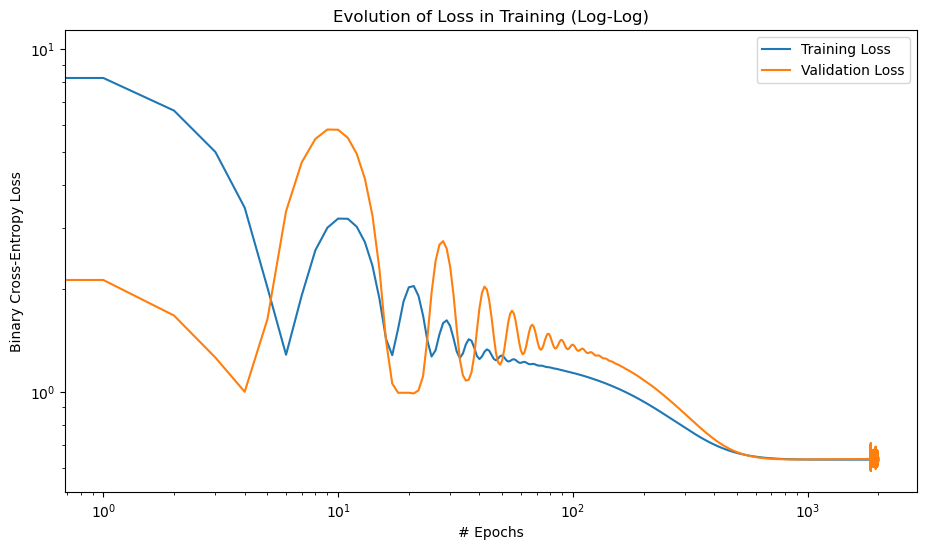

In [14]:
model = tf.keras.Sequential()
model.add(layers.Dense(8, activation = "relu"))
model.add(layers.Dense(1, activation = "sigmoid"))

w0 = len(y_train) / (2 * sum(y_train == 0))
w1 = len(y_train) / (2 * sum(y_train == 1))

_, X_val, _, y_val = train_test_split(X_test, y_test, test_size = 0.1)
model.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])
history = model.fit(X_train, y_train, epochs = 2000, batch_size = len(y_train), class_weight = {0: w0, 1: w1},
                    validation_data = (X_val, y_val), verbose = 0)

plt.figure(figsize = (11,6))
plt.loglog(history.history["loss"], label = "Training Loss")
plt.loglog(history.history["val_loss"], label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("# Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Evolution of Loss in Training (Log-Log)")
plt.show()

In [15]:
y_hat = model.predict(X_test)
positive_metrics.loc["NN",:] = metrics(y_hat, y_test, target = "positive")
negative_metrics.loc["NN",:] = metrics(y_hat, y_test, target = "negative")

104/104 [==============================] - 0s 808us/step


# 4) Gated Recurrent Network

In [16]:
gru_df = df.copy(deep = True)
gru_df = gru_df.drop(columns = ["reviewText"])
gru_df["summary"] = gru_df["summary"].astype(str).apply(lambda x: re.sub("[0-9]", "", x))

X_gru = gru_df["summary"]
Y_gru = np.where(gru_df["overall"] <= 3, 0, 1)
X_train_gru, X_test_gru, y_train_gru, y_test_gru = train_test_split(X_gru, Y_gru, test_size = 0.33)
_, X_val_gru, _, y_val_gru = train_test_split(X_test_gru, y_test_gru, test_size = 0.1)

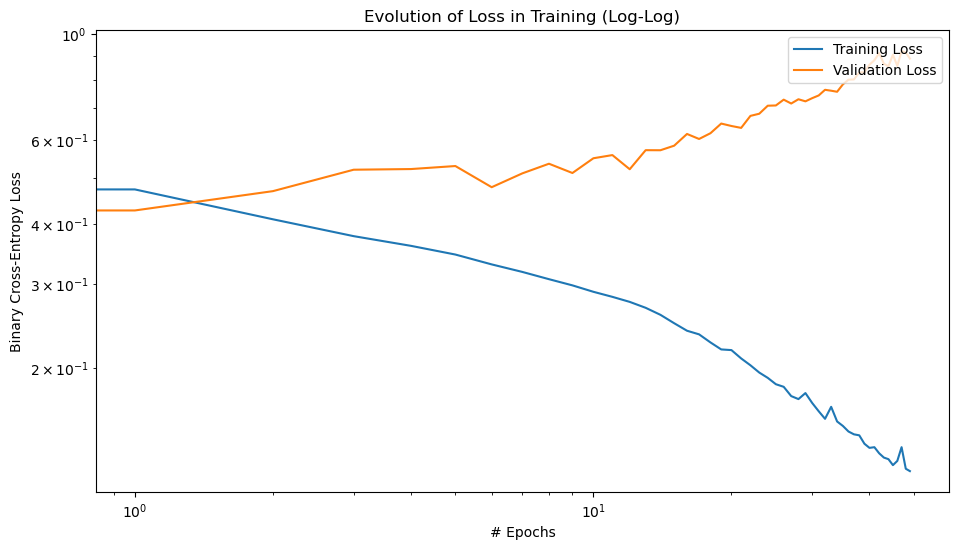

In [17]:
model = tf.keras.models.Sequential()
model.add(layers.Input(shape = (1,), dtype = tf.string))

vectorize_layer = layers.TextVectorization(max_tokens = 1000, output_mode = "int", output_sequence_length = 15)
text = tf.convert_to_tensor(gru_df["summary"].astype(str))
vectorize_layer.adapt(text)
model.add(vectorize_layer)

w0 = len(y_train) / (2 * sum(y_train == 0))
w1 = len(y_train) / (2 * sum(y_train == 1))

model.add(layers.Embedding(1000, 32))
model.add(layers.Bidirectional(layers.GRU(8)))
model.add(layers.Dense(1, activation = "sigmoid"))
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
history = model.fit(X_train_gru, y_train_gru, epochs = 50, class_weight = {0: w0, 1: w1}, 
                    validation_data = (X_val_gru, y_val_gru), verbose = 0)

plt.figure(figsize = (11,6))
plt.loglog(history.history["loss"], label = "Training Loss")
plt.loglog(history.history["val_loss"], label = "Validation Loss")
plt.legend(loc = "upper right")
plt.xlabel("# Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("Evolution of Loss in Training (Log-Log)")
plt.show()

In [18]:
y_hat = model.predict(X_test_gru)
positive_metrics.loc["GRU",:] = metrics(y_hat, y_test_gru, target = "positive")
negative_metrics.loc["GRU",:] = metrics(y_hat, y_test_gru, target = "negative")

104/104 [==============================] - 1s 2ms/step


# 5) Transformer

In [20]:
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path = checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
raw_inputs = list(X_test_gru.astype(str))
y_hat = np.empty(len(raw_inputs))
for i in range(0, len(raw_inputs), 100):
    j = min(i + 100, len(raw_inputs))
    inputs = tokenizer(raw_inputs[i:j], padding = True, truncation = True, return_tensors = "pt")
    outputs = model(**inputs)
    outputs = torch.nn.functional.softmax(outputs.logits, dim = -1)
    y_hat[i:j] = outputs[:,1].detach().numpy()

In [21]:
positive_metrics.loc["BERT",:] = metrics(y_hat, y_test_gru, target = "positive")
negative_metrics.loc["BERT",:] = metrics(y_hat, y_test_gru, target = "negative")

# Display Final Metrics

In [22]:
print("Positive Metrics:")
display(positive_metrics)

print("\n")

print("Negative Metrics:")
display(negative_metrics)

Positive Metrics:


,Accuracy,Precision,Recall,F
LR,0.719697,0.909292,0.740541,0.816286
NB,0.74697,0.904167,0.781982,0.838647
NN,0.728788,0.909051,0.752793,0.823576
GRU,0.805152,0.920046,0.84528,0.88108
BERT,0.820909,0.925162,0.85983,0.8913




Negative Metrics:


,Accuracy,Precision,Recall,F
LR,0.719697,0.307692,0.609524,0.408946
NB,0.74697,0.327778,0.561905,0.414035
NN,0.728788,0.315369,0.601905,0.413883
GRU,0.805152,0.386779,0.570539,0.461023
BERT,0.820909,0.419971,0.593361,0.491831
